In [17]:
import numpy as np 
import pandas as pd 
import scipy as sp
import sklearn 

import random
import time

# Model Algoriths
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier # conda install -c conda-forge xgboost

#Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

# Ignore the shitload of conversion warnings we get. 
import warnings
warnings.filterwarnings('ignore')

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

# Files live in the same folder as this notebook. 
submission_example = pd.read_csv('gender_submission.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Making a copy to play with. 
data1 = train.copy(deep = True)

# Making a list of both trains so we can clean them at once later.
data_cleaner = [data1, train]

Now that we're familiar with the data we need to first clean it.

The 4 C's:
Correcting - remove broken data. Like if age is 800 somewhere or something. Doesn't look like it.

Completing - filling null values. Many algorithms don't know how to deal so we need to fix. We need to impute missing values especially for age. We might need to change this process if we realize that filling it with the mean or something isn't working well. What I'm reading suggests we should use the median for age, drop the 'cabin' column and use mode to impute 'embark'. 

Create - Feature engineering

Converting - changing over dates or data types that don't work well. 

In [18]:
# train.info()
# train.describe()
# train.sample(10)

# going to work on having prettier print functions in this notebook.

# print('Train columns with null values:\n', data1.isnull().sum())
# print("-"*10)

# print('Test columns with nulls:\n', test.isnull().sum())
# print("-"*10)

# looks like the ratio of missing age and cabin are the same across the train and test sets.
# proof the sample is actually random between the two. 
# We need to fix these two columns along with Embarked if we can hope to model correctly.
# in the future I would make several different versions of these dataframes,
# testing different imputation methods to see which one works the best. 

In [19]:
# Filling the data

for dataset in data_cleaner: # do em both at once
    # Fill missing age
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True) # this doesn't work well without inplace
    
    # fill embarked
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
    
    # fill missing fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
    # we need to drop Passenger ID and ticket because they're just random identifiers with no purpose
    # we also want to drop Cabin because it has too many Nulls

drop_column = ['PassengerId', 'Cabin', 'Ticket'] # make a list it's easier
data1.drop(drop_column, axis=1, inplace = True) # axis means column, inplace makes it persistent without needing to make a new variable



# Time to create some features for both datasets. 

for dataset in data_cleaner:
    # How about creating family size per person? 
    # makes sense that families would work together to survive
    # and families prioritized in lifeboats
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1 # plus one to account for the person themselves
    
    dataset['IsAlone'] = 1
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0
    # if you are alone, it's a 1, if not, it's a zero
    # this is a binary column
    
    # The names have titles with them, "Mr" "Miss" "Master" so let's cut those off and turn them into a feature!
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    
    # We should also place the fares into bins. I don't really know how this works but I'm going to try qcut
    # Ref: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.qcut.html
    # Ref: https://stackoverflow.com/questions/30211923/what-is-the-difference-between-pandas-qcut-and-pandas-cut
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)
    
    # Using regular cut to bin the ages:
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)
    
    

# So here's where I'm getting some guidance from other notebooks. We need to clean up rare title names.
# print(data1['Title'].value_counts())
# Like, lmaowtf: https://en.wikipedia.org/wiki/Jonkheer

stat_min = 10 
# Using ten as the minimum because this article says so: http://nicholasjjackson.com/2012/03/08/sample-size-is-10-a-magic-number/
title_names = (data1['Title'].value_counts() < stat_min) # creates a true/false series with title name as the index

# What we're going to do is replace the random ones below ten. 
# lambda functions 

data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(data1['Title'].value_counts())

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64


We need to convert categorical data to dummy variables for mathematical analysis. We're going to encode using the inherent sklearn and pandas tools, nothing fancy. 

I know that SciKit has a new library called ColumnTransformer that has replaced LabelEncoding but I haven't learned how to use it yet. 

https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621

Let's try to use this next time:
https://towardsdatascience.com/columntransformer-in-scikit-for-labelencoding-and-onehotencoding-in-machine-learning-c6255952731b


In [20]:
label = LabelEncoder()

In [21]:
for dataset in data_cleaner:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])

# We now can define a y variable, the target outcome:
Target = ['Survived']

# Defining the X variables for feature selection
data1_x = ['Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] # pretty names for charts
data1_x_calc = ['Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'SibSp', 'Parch', 'Age', 'Fare'] # These are the actual coded columns we're gonna use

data1_xy = Target + data1_x # combining them 

# Define the x variables for the origiunal data with bin features to remove any continuous variables
data1_x_bin = ['Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data_xy_bin = Target + data1_x_bin  # so what we've done is made two versions of the test data, one continuous and one binned

# We need to turn the categorical variables into dummy variables, putting them in their own columns with binary 1/0 data inside them.
data1_dummy = pd.get_dummies(data1[data1_x]) # ran this on that list of column names from above
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy # add the target variable, naturally


In [22]:
data1_dummy.head()

,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,0,1,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,0,1
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,0,1,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,0,1
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,0,1,0


Now that we've put together all our data, we need to split some test and train data sets. 

In [23]:
# first split using randomstate
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state = 0) # using the preset variables from above to keep this function clean. 
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target], random_state = 0) # doing the same, but with bins

train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)

Now that the data is clean, we're going to explore the data and see if we can find some basic correlations to inform what we do next. I have some ideas, but for the sake of science let's examine everything equally. 

In [24]:
for x in data1_x:
     if data1[x].dtype != 'float64' : 
            print('Survival Correlation by:', x)
            print(data1[[x, Target[0]]].groupby(x, as_index=False).mean())

print(pd.crosstab(data1['Title'], data1[Target[0]]))

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
Survival Correlation by: Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
Survival Correlation by: FamilySize
   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4       

In [25]:
# skipping visualization because we need faster, better ways to do it. Next step, modeling. 

In [26]:
# "No Free Lunch Theorem" = there is no super algorithm that works best. The best approach is to try several and pick the one that works best for your situation.
# to that end, we're going to set up a bunch and try them.

# I love this format because this is some copy/paste code we can run again to quickly run the data through every single algorithm, score them and easily visualize. 
# Should we turn this into a function eventually? I'm game for it 

MLA = [
    # Ensemble
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    # Gaussian Process
    gaussian_process.GaussianProcessClassifier(),
    
    # GLM
    linear_model.LogisticRegression(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifier(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    # Naive Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    # Nearest Neighbors
    neighbors.KNeighborsClassifier(),
    
    # SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    # Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    # Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    #xgboost MONEY GANG
    XGBClassifier()
    
]

In [27]:
# Going to try splitting in cross-validation with this splitter class, which is an alternative to train_test_split
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit

cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0) # this intentionally leaves out 10% of the model - I am not sure why this is a good idea but I hear it is

# We are going to create a table to compare all the MLAs and see what their score is
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD', 'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

# Create table to compare MLA predictions
MLA_predict = data1[Target]



In [28]:
# Index through the MLA and save the performance to put it in a table - this is the money moment. 
# Really should wrap this in a function for ease of use later. Does one of those exist already, maybe?

row_index = 0
for alg in MLA:
    
    # set the name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    # We are going to score the model with cross validation.
    # http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    
    cv_results = model_selection.cross_validate(alg, data1[data1_x_bin], data1[Target], cv = cv_split, return_train_score=True) # The code has changed since the guide went live. You now have to tell it to return the train score. 
    
    # simply reference the cv_results output column by column and format it the way we want. 
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean() # How long does it take? We're speed racers out here


    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    
    # If this is a non-bias random sample, then +/- 3 standard deviations from the mean should statistically capture 99.7% of the subsets. 
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3 # This will tell us the worst that can happen
    
    # save them for export
    alg.fit(data1[data1_x_bin], data1[Target])
    MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
    
    row_index+=1 # add one to the row index so it moves to the next row.
    
    
# print and sort the table. 
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending=False, inplace = True)

In [29]:
# perry aye 

In [31]:
MLA_compare.head()

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.856367,0.829478,0.0527546,0.0443746
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.890824,0.827985,0.0526119,0.0111429
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.837266,0.826119,0.0453876,0.0302742
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.866667,0.822761,0.0498731,0.0623156
17,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895131,0.822761,0.0520853,0.00369406


Text(0, 0.5, 'Algorithm')

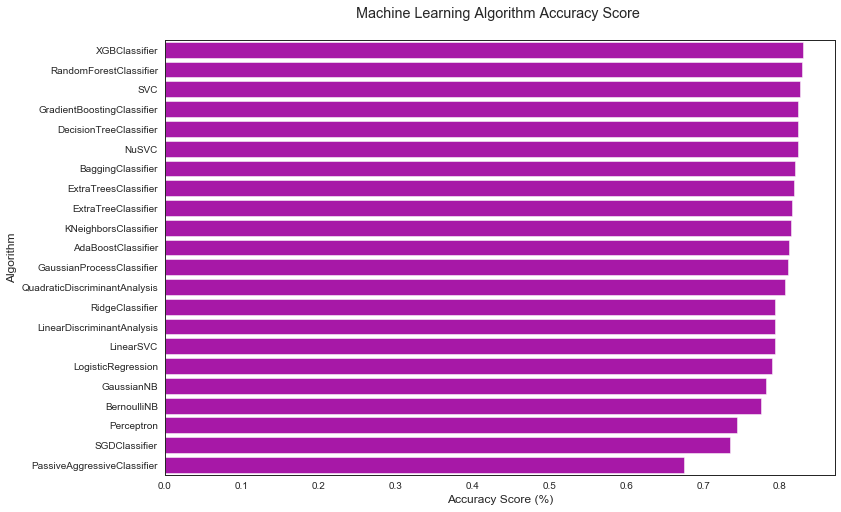

In [33]:
import seaborn as sns

# lets take a look eh
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

So right out the gate we were able to get like 82% which is phenomenal. The next step is to figure out - is it going to be worth our time to improve this? If we are going to get a five percent increase for 3 months of work, maybe. But if we get .0001% increase no way. 

Before we decide how to make our model better we need to decide if it's worth keeping. One trick is to look at the data ourselves. We know that 67.5% of the people on the titanic died. If we guess on each person that each person died, we'd be right 67.5% of the time. So that's our baseline - anything lower than 68% is bad model performance, because why would I need it? We could just say everyone died and get a better score. 

Before we do that, let's just look at a manual decision tree, something we can do every time we look at data to see if just screwing around we can get a better model than a computer. This defines our "baseline" of performance to know if we should try to make it better or not. 


Copy and pasting the below for reference from this guy's guide. 

Our rule of thumb will be the majority rules. Meaning, if the majority or 50% or more survived, then everybody in our subgroup survived/1, but if 50% or less survived then if everybody in our subgroup died/0. Also, we will stop if the subgroup is less than 10 and/or our model accuracy plateaus or decreases. Got it? Let's go!

Question 1: Were you on the Titanic? If Yes, then majority (62%) died. Note our sample survival is different than our population of 68%. Nonetheless, if we assumed everybody died, our sample accuracy is 62%.

Question 2: Are you male or female? Male, majority (81%) died. Female, majority (74%) survived. Giving us an accuracy of 79%.

Question 3A (going down the female branch with count = 314): Are you in class 1, 2, or 3? Class 1, majority (97%) survived and Class 2, majority (92%) survived. Since the dead subgroup is less than 10, we will stop going down this branch. Class 3, is even at a 50-50 split. No new information to improve our model is gained.

Question 4A (going down the female class 3 branch with count = 144): Did you embark from port C, Q, or S? We gain a little information. C and Q, the majority still survived, so no change. Also, the dead subgroup is less than 10, so we will stop. S, the majority (63%) died. So, we will change females, class 3, embarked S from assuming they survived, to assuming they died. Our model accuracy increases to 81%.

Question 5A (going down the female class 3 embarked S branch with count = 88): So far, it looks like we made good decisions. Adding another level does not seem to gain much more information. This subgroup 55 died and 33 survived, since majority died we need to find a signal to identify the 33 or a subgroup to change them from dead to survived and improve our model accuracy. We can play with our features. One I found was fare 0-8, majority survived. It's a small sample size 11-9, but one often used in statistics. We slightly improve our accuracy, but not much to move us past 82%. So, we'll stop here.

Question 3B (going down the male branch with count = 577): Going back to question 2, we know the majority of males died. So, we are looking for a feature that identifies a subgroup that majority survived. Surprisingly, class or even embarked didn't matter like it did for females, but title does and gets us to 82%. Guess and checking other features, none seem to push us past 82%. So, we'll stop here for now.

You did it, with very little information, we get to 82% accuracy. On a worst, bad, good, better, and best scale, we'll set 82% to good, since it's a simple model that yields us decent results. But the question still remains, can we do better than our handmade model?

In [39]:
# time to tune hyperparameters

dtree = tree.DecisionTreeClassifier(random_state = 0)
base_results = model_selection.cross_validate(dtree, data1[data1_x_bin], data1[Target], cv = cv_split, return_train_score=True)
dtree.fit(data1[data1_x_bin], data1[Target])

print('BEFORE DT Parameters: ', dtree.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
#print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)

BEFORE DT Parameters:  {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
BEFORE DT Training w/bin score mean: 89.51
BEFORE DT Test w/bin score mean: 82.09
BEFORE DT Test w/bin score 3*std: +/- 5.57
----------
